In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

In [ ]:
f_path = "./results"

In [3]:
# ECAI-ready style
plt.style.use('seaborn-v0_8-paper')
plt.rcParams.update({
    'font.size': 9,
    'axes.labelsize': 9,
    'axes.titlesize': 9,
    'legend.fontsize': 7,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'lines.linewidth': 0.8,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'axes.edgecolor': 'black',
    'axes.linewidth': 0.8,
    'text.usetex': True
})

# Colors
bound_color = "#ff441a"      # red
BN_color = "#3934fe"         # blue
CN_color = "#30d378"         # green

#Plot BN and bound
def plot_bn_bound(exp: str, ax):

    # Import results
    results = os.listdir(f_path)
    r_path = [r for r in results if f"{exp}-ess1.csv" in r][0]
    result = pd.read_csv(f"{f_path}/{r_path}")
    error = result["error"]
    bound = result["power_bound"]
    bn_cols = [c for c in result.columns if "BN" in c]
    bn_mean = result.loc[:,bn_cols].mean(axis=1)
    bn_max = result.loc[:,bn_cols].max(axis=1)

    # Plot bound
    ax.semilogx(error, bound, '^', color=bound_color, label='Bound', markersize=4, zorder=1)

    # Plot BN (avg-max)
    ax.fill_between(error, bn_mean, bn_max, color=BN_color, alpha=0.2, zorder=0)
    ax.semilogx(error, bn_mean, '-', color=BN_color, label='BN avg', zorder=0)

    # Title and axes
    ax.set_xlim(10e-5*0.5, 1)
    ax.set_xlabel('Error')
    ax.set_ylabel('Power')
    # ax.set_xticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.5])
    # ax.set_xticklabels(["$10^{-5}$", "$10^{-4}$", "$10^{-3}$", "$10^{-2}$", "$10^{-1}$", "0.5"])

# Plot CN (for a given ess)
def plot_cn(exp, ax, ess: int, color: str, type: str):

    # Import results
    results = os.listdir(f_path)
    r_path = [r for r in results if f"{exp}-ess{ess}.csv" in r][0]
    result = pd.read_csv(f"{f_path}/{r_path}")
    error = result["error"]
    cn_cols = [c for c in result.columns if "CN" in c]
    cn_mean = result.loc[:,cn_cols].mean(axis=1)
    cn_max = result.loc[:,cn_cols].max(axis=1)

    # Plot CN (avg-max)
    ax.fill_between(error, cn_mean, cn_max, color=color, alpha=0.2, zorder=0)
    ax.semilogx(error, cn_mean, type, color=color, label=f'CN avg (S={ess})', zorder=0)

    # Legend
    if exp == "exp0":
        ax.legend(loc='best', frameon=True, fancybox=True)

# Plot title function
def get_title(exp: str):
    with open(f"{f_path}/exp_meta.txt", "r") as meta:
        for row in meta:
            if exp in row:
                pieces = row.split()
                n = int(pieces[pieces.index('Nodes:') + 1])
                e = int(pieces[pieces.index('Edges:') + 1])
                c = int(pieces[pieces.index('Complexity:') + 1])
                return n, e, c


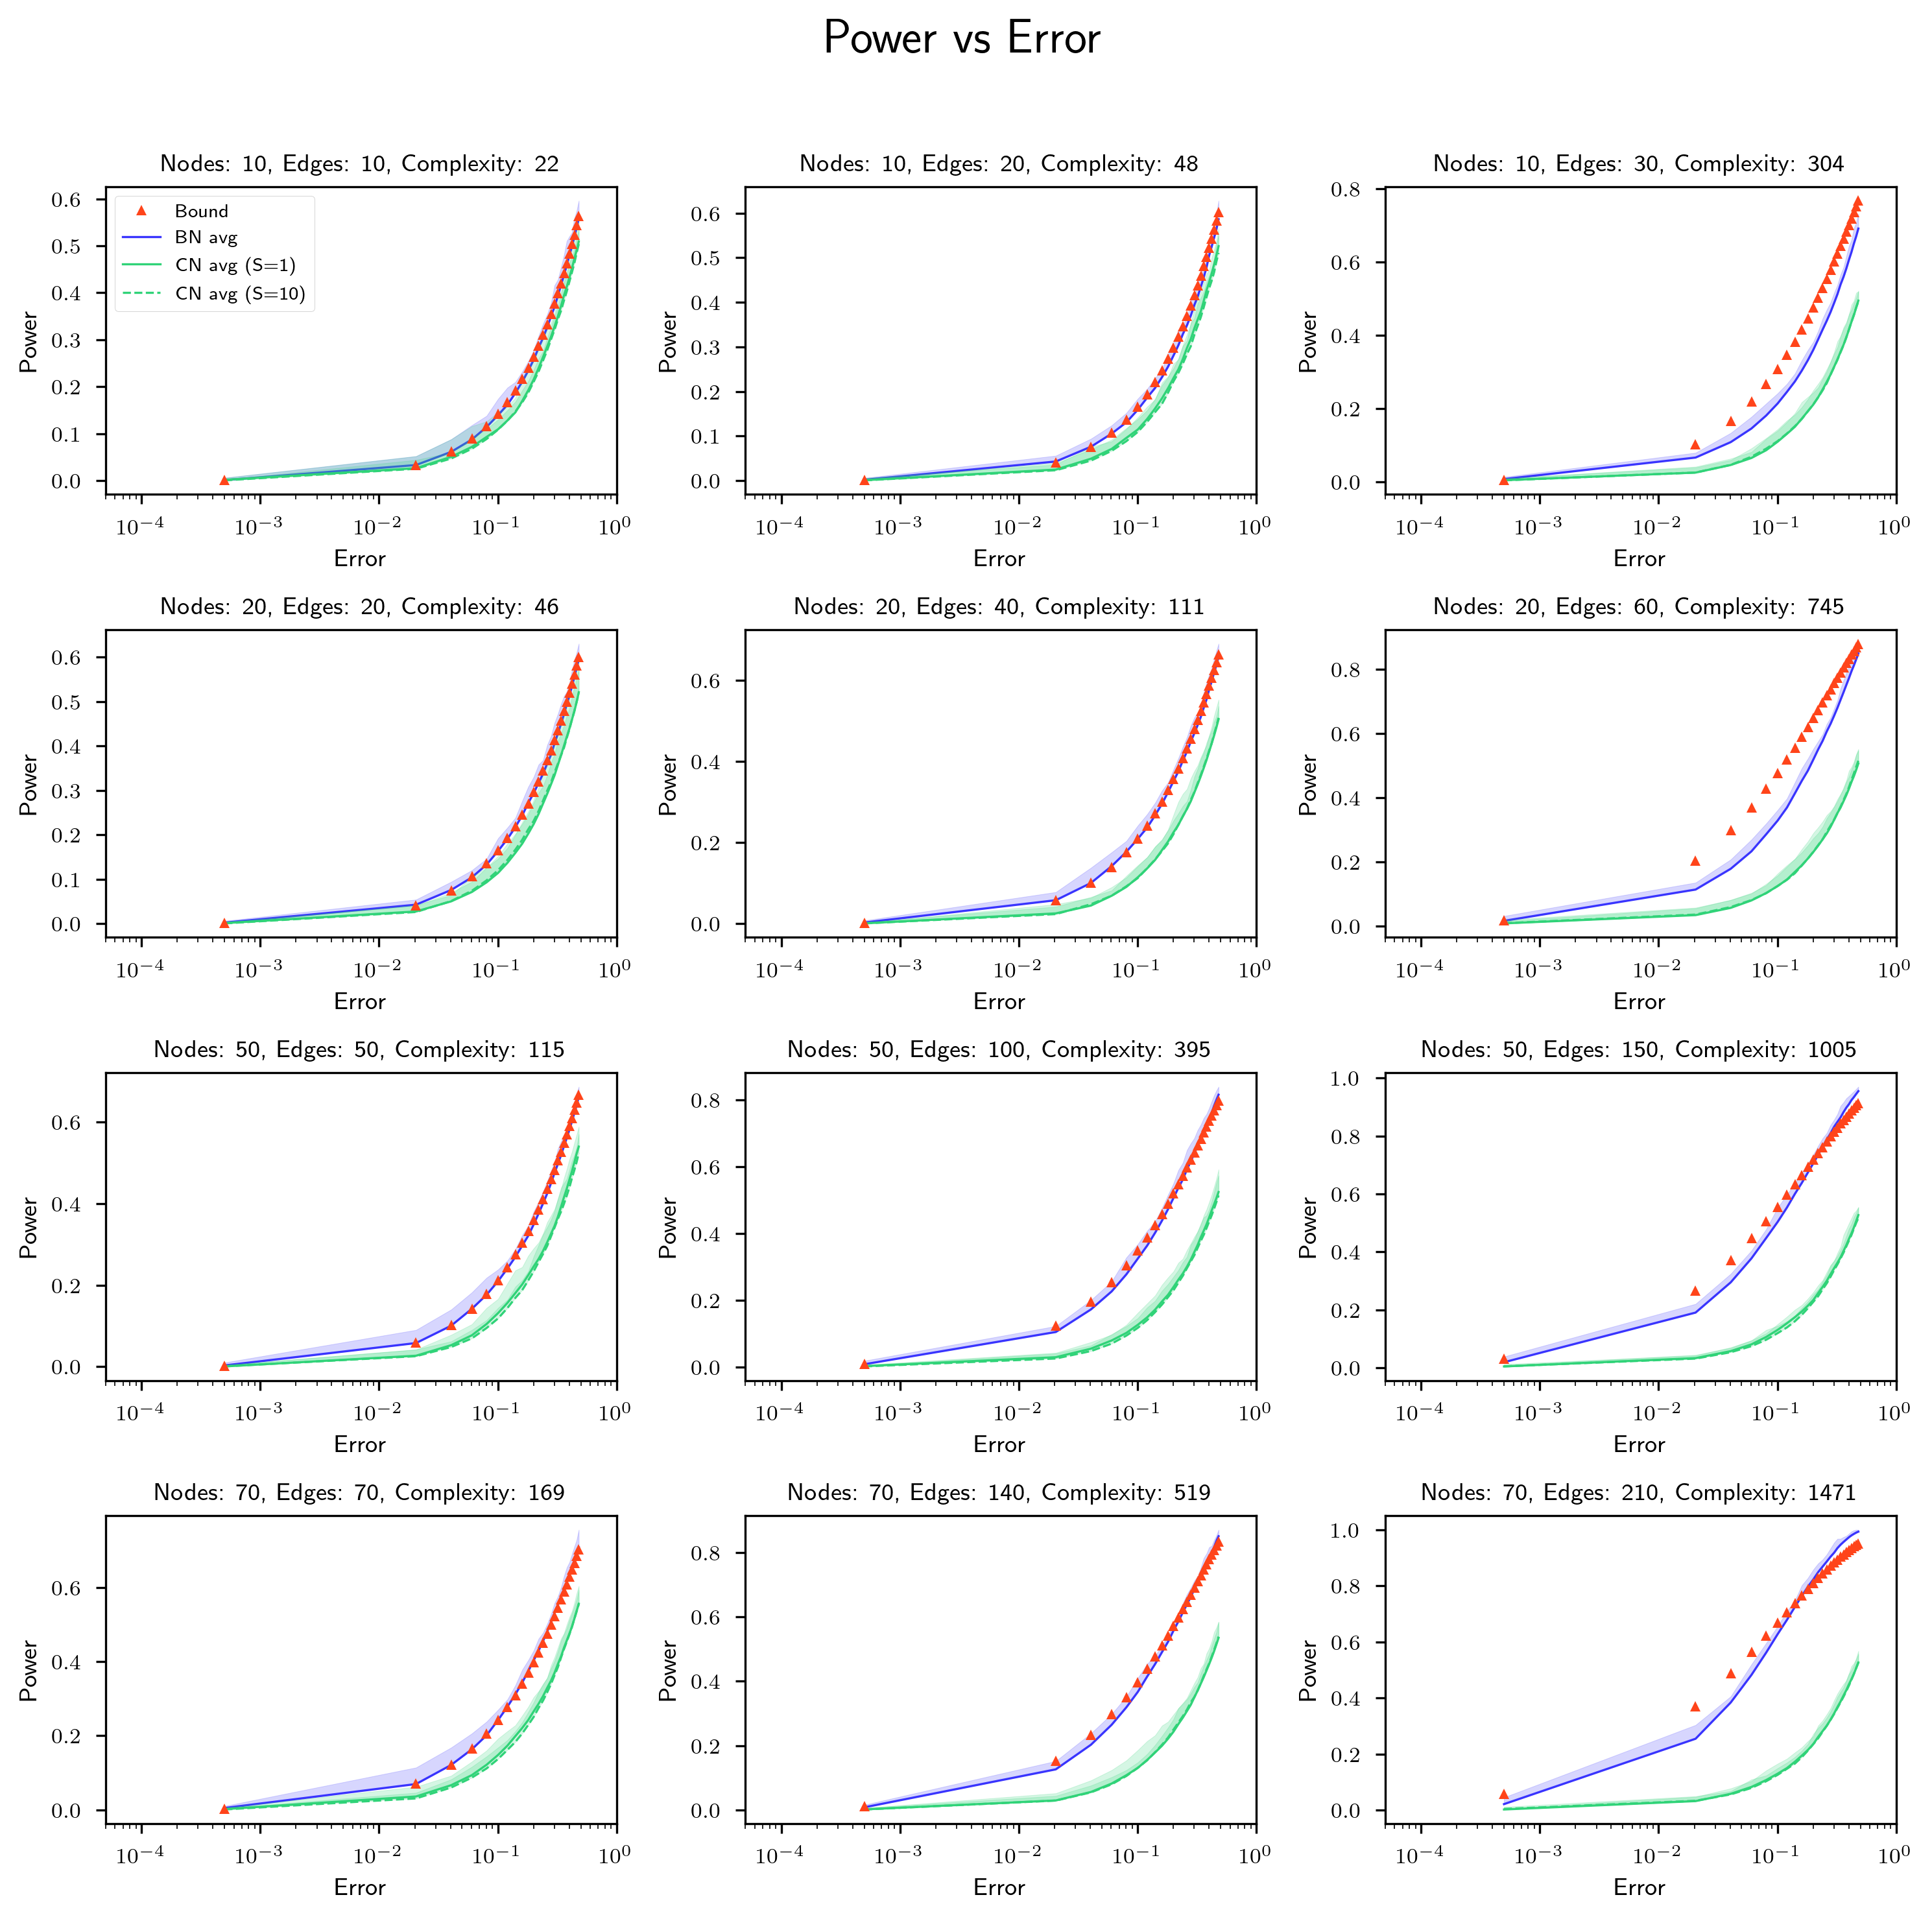

In [4]:
# Layout 4x3
fig, axes = plt.subplots(4, 3, figsize=(10, 10))
fig.suptitle("Power vs Error", fontsize=18)

exps = ["exp0", "exp1", "exp2",
        "exp4", "exp5", "exp6",
        "exp8", "exp9", "exp10",
        "exp12", "exp13", "exp14"]

# Loop su tutti i subplot
for i, ax in enumerate(axes.flat):
    plot_bn_bound(f"{exps[i]}", ax)
    plot_cn(f"{exps[i]}", ax, ess = 1, color = CN_color, type="-")
    plot_cn(f"{exps[i]}", ax, ess = 10, color = CN_color, type="--")
    (n, e, c) = get_title(exps[i])
    ax.set_title(f"Nodes: {n}, Edges: {e}, Complexity: {c}")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
